## Problem 3: K-Means Clustering and Centroid Norm Averaging

In this task, you will generate $n = 10000$ samples from a 2D Gaussian distribution and apply the k-means algorithm to cluster the data into $k = 3$ clusters. You will calculate the average of the centroid norms and analyze how the cumulative average converges over multiple iterations. The goal is to empirically estimate the number of iterations required to achieve a stable result with $9$-digit accuracy.

In [65]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

* Generate $n = 10000$ samples ($x_1^i, x_2^i$) from a $2D$ Gaussian distribution.

In [4]:
n_samples = 10000
mean = [0, 0]
# identity covariance matrix for standard normal distribution
cov = [[1, 0], [0, 1]]
data = np.random.multivariate_normal(mean, cov, n_samples)

Other ways to generate data

In [8]:
# standard gaussian (mean=0, std=1)
data1 = np.random.randn(n_samples, 2)

x = np.random.normal(0, 1, n_samples)
y = np.random.normal(0, 1, n_samples)
data2 = np.array([x, y]).T

Plot the data

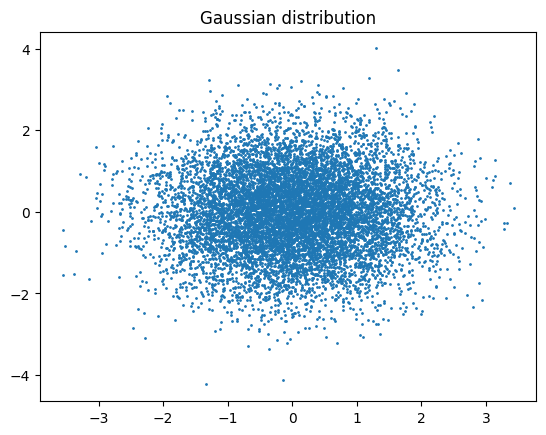

In [11]:
plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=1)
plt.title('Gaussian distribution')
plt.show()

* Apply the $k$-means clustering algorithm with $k = 3$
* For each centroid $(C_1^j, C_2^j)$, $j = 1, 2, 3$, calculate its norm: $∥C^j∥ = \sqrt{(C_1^j)^2 + (C_2^j)^2}$
* Average the norms of the three centroids and call this value $R_1$
* Repeat this process $88$ times (or more) to get the values $R_1, R_2, ..., R_{88}$

In [47]:
# parameters
k = 3  # number of clusters
n_iterations = 20000 # 88

# run K-Means clustering and calculate the average norm of centroids for each iteration
average_norms = []
for i in range(n_iterations):
    # random_state=None
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=i)
    kmeans.fit(data)
    centroids = kmeans.cluster_centers_

    norms = np.linalg.norm(centroids, axis=1)

    avg_norm = np.mean(norms)
    average_norms.append(avg_norm)


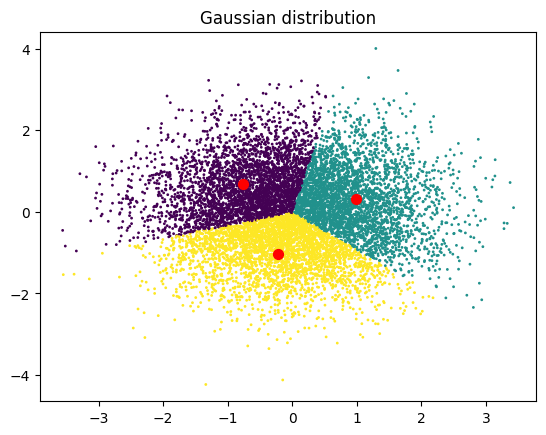

In [48]:
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data)
centroids = kmeans.cluster_centers_
clusters = kmeans.predict(data)

plt.figure()
# plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, s=1)
plt.scatter(data[:, 0], data[:, 1], c=clusters, s=1)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.title('Gaussian distribution')
plt.show()

* Calculate the cumulative average of the $R_i$ values as $\frac{1}{n} \sum_{i=1}^n R_i$ for $n = 1, 2, ..., 88$ (or more)

In [49]:
cumulative_averages = np.cumsum(average_norms) / np.arange(1, n_iterations + 1)

Plot the cumulative averages and analyze how the value converges

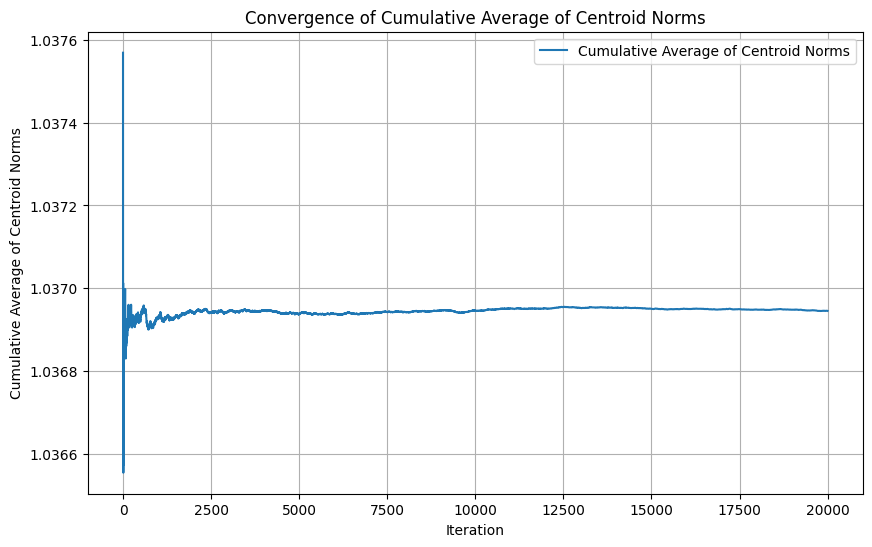

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_averages, label="Cumulative Average of Centroid Norms")
plt.xlabel("Iteration")
plt.ylabel("Cumulative Average of Centroid Norms")
plt.title("Convergence of Cumulative Average of Centroid Norms")
plt.legend()
plt.grid(True)
plt.show()

* Task: Empirically estimate the number of iterations needed instead of $88$ to achieve $9$-digit accuracy in the cumulative averages

Calculate the differences between cumulative averages

In [62]:
diff_cumulative_averages = []

for i in range(1, n_iterations):
    # check if cumulative average difference between iterations is below tolerance
    diff = abs(cumulative_averages[i] - cumulative_averages[i-1])
    diff_cumulative_averages.append(diff)

If the data is linear in a log-log plot, it suggests that the relationship between $x$ and $y$ follows a **power-law function** of the form: $y = a \cdot x^b$, where $a$ and $b$ are constants, with $b$ being the slope of the line on the log-log plot.

To estimate this relationship and find the $x$ value for a given $y$, we can:
* fit a linear model in log-log space to estimate $a$ and $b$
* use the model to predict the $x$ value for a specified $y$

* Fitting the Model: We use curve_fit to fit the power-law function $y = a \cdot x^b$ to the data
* Estimating $x$ for a given $y$: We rearrange the power-law equation to solve for $x$ given $y$: $x = (\frac{y}{a})^\frac{1}{b}$

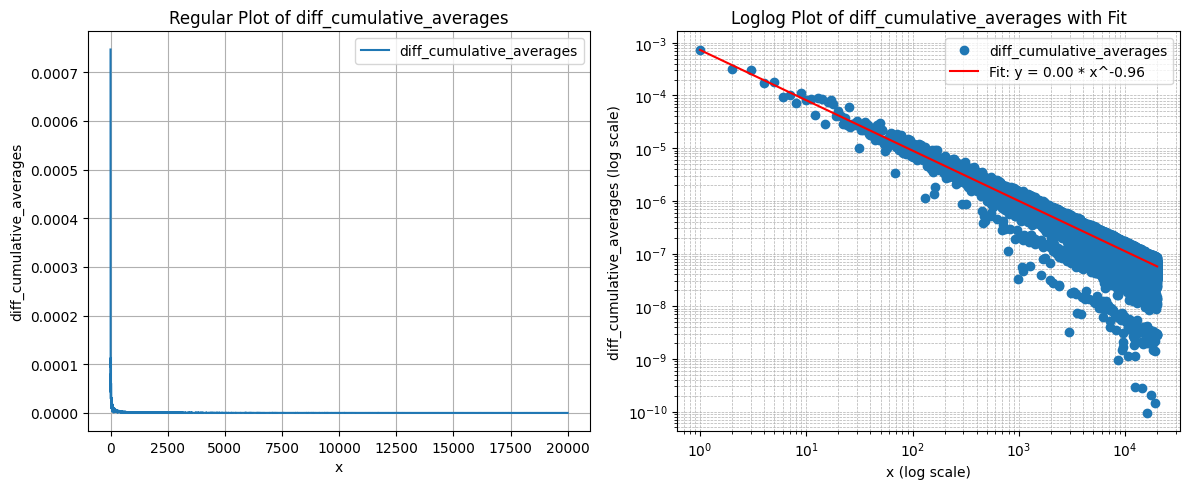

For y = 1e-09, estimated x = 1371792


In [66]:
x_values = np.arange(1, len(diff_cumulative_averages) + 1)
y_values = np.array(diff_cumulative_averages)

# define the power law function y = a * x^b
def power_law(x, a, b):
    return a * np.power(x, b)

# fit the log-log model
popt, pcov = curve_fit(power_law, x_values, y_values)
a, b = popt  # extract the fitted parameters

# function to estimate x for a given y using the power law fit
def estimate_x_for_y(y_target):
    return (y_target / a) ** (1 / b)

# plotting
plt.figure(figsize=(12, 5))

# first subplot: regular plot
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values, label="diff_cumulative_averages")
plt.xlabel("x")
plt.ylabel("diff_cumulative_averages")
plt.title("Regular Plot of diff_cumulative_averages")
plt.legend()
plt.grid(True)

# second subplot: loglog plot with the fitted line
plt.subplot(1, 2, 2)
plt.loglog(x_values, y_values, label="diff_cumulative_averages", marker='o', linestyle='none')
plt.loglog(x_values, power_law(x_values, *popt), label=f"Fit: y = {a:.2f} * x^{b:.2f}", color='red')
plt.xlabel("x (log scale)")
plt.ylabel("diff_cumulative_averages (log scale)")
plt.title("Loglog Plot of diff_cumulative_averages with Fit")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()

# example of calculating x for a given y
y_target = 1e-9 # tolerance
x_for_y_target = estimate_x_for_y(y_target)
x_for_y_target_rounded = math.ceil(x_for_y_target)
print(f"For y = {y_target}, estimated x = {x_for_y_target_rounded}")


Determine convergence by checking when the difference in cumulative average is less than $10^{-9}$

In [64]:
tolerance = 1e-9
converged = False

for i in range(len(diff_cumulative_averages)):
    # check if cumulative average difference between iterations is below tolerance
    if diff_cumulative_averages[i] < tolerance:
        print(f"Convergence achieved at iteration {i+1} with cumulative average: {cumulative_averages[i]:.9f}")
        converged = True
        break

if not converged:
    print("Convergence not achieved within the specified number of iterations.")

Convergence achieved at iteration 8655 with cumulative average: 1.036943654
